In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.conf.continuous_conf import ContinuousConf
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [5]:
import re

#setup
results = pd.read_pickle('17_06/results.pkl')
# results = pd.read_pickle('../simulation_engine/results/binaryIV/06_06/12/results.pkl')
binaryIV = ContinuousConf('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results.columns.tolist()


['seed',
 'b_U_X',
 'b_X_Y',
 'b_U_Y',
 'sigma_X',
 'sigma_Y',
 'sigma_U',
 'intercept_X',
 'intercept_Y',
 'g_U_X',
 'g_U_Y',
 'squash_X',
 'squash_Y',
 'ATE_true',
 'PNS_true',
 'p_Y1_mean',
 'p_Y0_mean',
 'U',
 'X',
 'Y',
 'epsilon_X',
 'epsilon_Y',
 'sigma_X_vec',
 'sigma_Y_vec',
 'Y_max',
 'Y_min',
 'X_max',
 'X_min',
 'X_mean',
 'Y_mean',
 'entropy_X',
 'ATE_causaloptim--binned_bound_lower',
 'ATE_causaloptim--binned_bound_upper',
 'ATE_causaloptim--binned_bound_valid',
 'ATE_causaloptim--binned_bound_width',
 'ATE_causaloptim--binned_bound_failed',
 'ATE_autobound--binned_bound_lower',
 'ATE_autobound--binned_bound_upper',
 'ATE_autobound--binned_bound_valid',
 'ATE_autobound--binned_bound_width',
 'ATE_autobound--binned_bound_failed',
 'ATE_zaffalonbounds--binned_bound_lower',
 'ATE_zaffalonbounds--binned_bound_upper',
 'ATE_zaffalonbounds--binned_bound_valid',
 'ATE_zaffalonbounds--binned_bound_width',
 'ATE_zaffalonbounds--binned_bound_failed',
 'ATE_OLS-0.99_bound_lower',
 '

In [8]:
# remove all cols that cotain 'tianpearl' 
cols_to_remove = [col for col in results.columns if 'tianpearl' in col or 'manski' in col]
results2 = results.drop(columns=cols_to_remove)
print('Removed columns:', cols_to_remove)
results2
scenario = ContinuousConf('DAG', results2)
scenario.run(['ATE_entropybounds-randomTheta--binned',
              'ATE_tianpearl--binned',
              'ATE_manski--binned',
              ])
results2 = scenario.data

Removed columns: []
Running ATE_entropybounds-randomTheta--binned...
Entering binned Binary Scenario for algorithm: ATE_entropybounds-randomTheta
Running ATE_entropybounds-randomTheta...


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 8
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 8
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 8
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 8
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
ATE_entropybounds-randomTheta completed in 289.40 seconds.
Total runtime: 289.40 seconds.
Exiting binned Binary Scenario.
ATE_entropybounds-randomTheta--binned completed in 289.40 seconds.
Running ATE_tia

In [11]:
pd.to_pickle(results2, '17_06/results.pkl')

                            Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
                         ATE_OLS-0.95          0.00            72.85          0.0939      1.4825          6.03
                         ATE_OLS-0.98          0.00            69.70          0.1104      1.4274          6.06
                         ATE_OLS-0.99          0.00            67.65          0.1200      1.3918          6.09
       ATE_entropybounds-0.10--binned          0.20            16.28          0.5840      0.8170          6.73
       ATE_entropybounds-0.20--binned          0.20             7.97          0.7546      0.8561          6.55
           ATE_zaffalonbounds--binned          0.00            16.90          0.7632      0.9722          7.89
ATE_entropybounds-randomTheta--binned          0.20             9.02          0.8733      0.9770          6.34
       ATE_entropybounds-0.80--binned          0.20             4.61          0.9898      1.0383          5.57
 

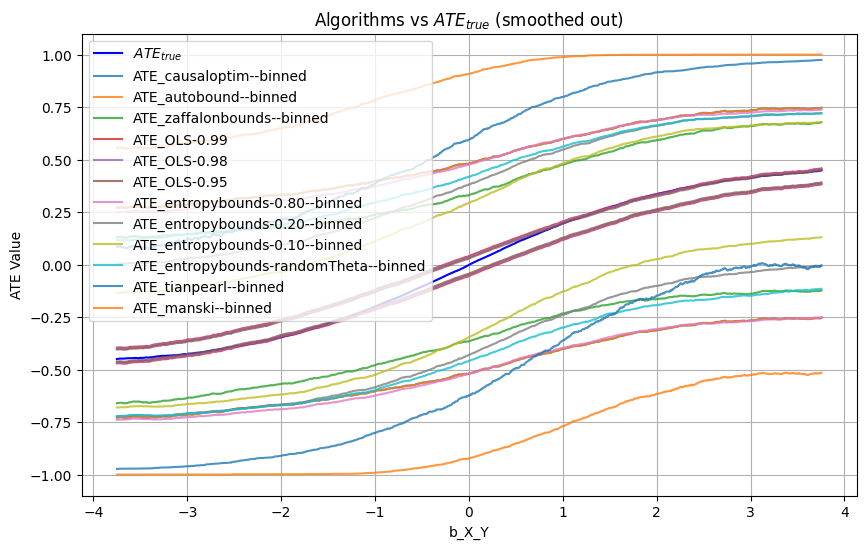

In [10]:
#ATE Evaluation
df = results2.copy()
# Extract unique algorithm names from columns like 'ATE_{algorithm_name}_{...}'
algorithm_names = PlottingUtil.extract_algorithm_names(df, 'ATE')
PlottingUtil.print_bound_statistics_table(df, algorithm_names)
PlottingUtil.plot_smoothed_query_vs_bounds(df, 'ATE', algorithm_names, 500)

ATE algorithms: ['causaloptim--binned', 'autobound--binned', 'zaffalonbounds--binned', 'OLS-0.99', 'OLS-0.98', 'OLS-0.95', 'entropybounds-0.80--binned', 'entropybounds-0.20--binned', 'entropybounds-0.10--binned', 'manski', 'tianpearl']
PNS algorithms: ['tianpearl']


d:\TUM Workspace\Thesis Workspace\causal-bounds\contConf\..\simulation_engine\util\plotting_util.py:334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  None


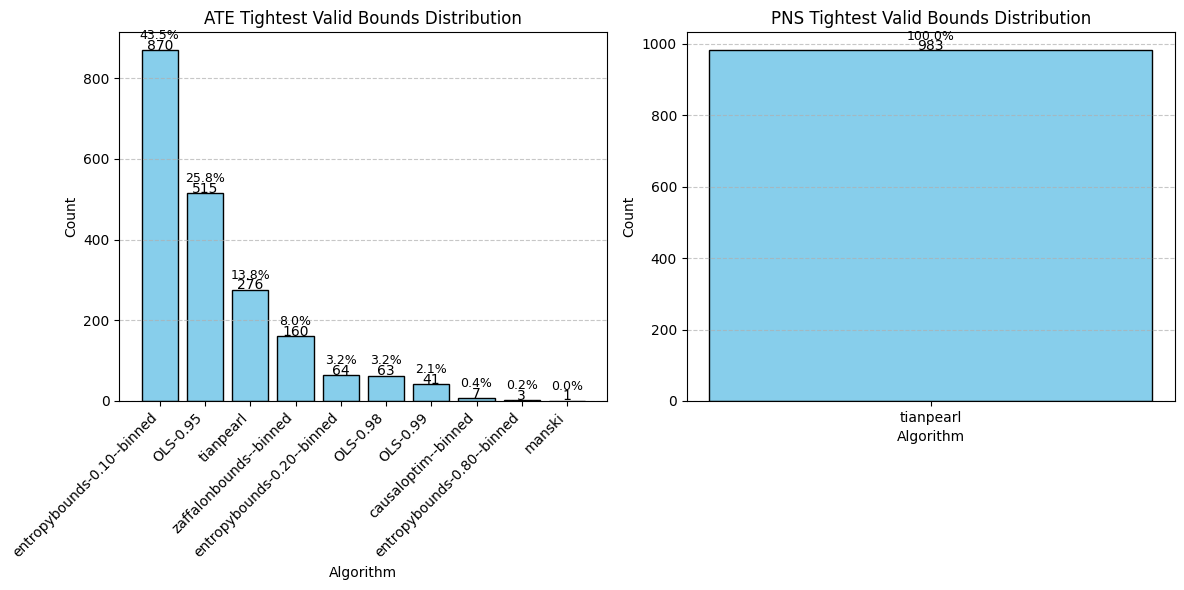

In [17]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
